# 1 - AgriPV Systems

This journal shows how to model an AgriPV site, calculating the irradiance not only on the modules but also the irradiance received by the ground to evaluate available solar ersource for plants. 

We assume that bifacia_radiacne is already installed in your computer. This works for bifacial_radiance v.3 release.

These journal outlines 4 useful uses of bifacial_radiance and some tricks: 

* Creating the modules in the AgriPV site
* Adding extra geometry for the pillars/posts supporting the AgriPV site
* Hacking the sensors to sample the ground irradiance and create irradiance map
* Adding object to simulate variations in ground albedo from different crops between rows.


#### Steps:

1. <a href='#step1'> Generate the geometry </a>
2. <a href='#step2'> Analyse the Ground Irradiance </a>
3. <a href='#step3'> Analyse and MAP the Ground Irradiance </a>
4. <a href='#step4'> Adding different Albedo Section </a>
    
#### Preview of what we will create: 
    
![Another view](images/AgriPV_2.PNG)
![AgriPV Image We will create](images/AgriPV_1.PNG)
And this is how it will look like:

![AgriPV modeled step 4](images/AgriPV_step4.PNG)




<a id='step1'></a>

## 1. Generate the geometry 

This section goes from setting up variables to making the OCT axis. 

For creating the 3-up landscape collector, we set ``numpanels = 3``

In [1]:
import os
from pathlib import Path

testfolder = str(Path().resolve().parent / 'TEMP' /  'Tutorial_1')

if not os.path.exists(testfolder):
    os.makedirs(testfolder)
    
print ("Your simulation will be stored in %s" % testfolder)

Your simulation will be stored in C:\Users\sayala\Documents\GitHub\InSPIRE\TEMP\Tutorial_1


In [2]:
import bifacial_radiance as br
import numpy as np
import pandas as pd

br.__version__

'0.4.2+159.gf121108.dirty'

In [3]:
# This information helps with debugging and getting support :)
import sys, platform
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("bifacial_radiance version ", br.__version__)

Working on a  Windows 10
Python version  3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]
Pandas version  2.0.3
bifacial_radiance version  0.4.2+159.gf121108.dirty


In [7]:
simulationname = 'tutorial_1'

# Location:
lat = 40.0583  # NJ
lon = -74.4057  # NJ

# Scene Parameters:
azimuth_ang=180 # Facing south
tilt =35 # tilt.

# MakeModule Parameters
moduletype='test-module'
numpanels = 3  # AgriPV site has 3 modules along the y direction
module_x = 2 # 2 m
module_y = 1 # m. slope we will measure
# if x > y, landscape. if x < y, portrait
xgap = 2.0#
ygap = 0.01 # Leaving 10 centimeters between modules on y direction
sensorsy = 6*numpanels  # this will give 6 sensors per module, 1 per cell

# TorqueTube Parameters
tubetype='square' # Other options: 'square' , 'hex'
material = 'Metal_Grey' # Other options: 'black'
diameter = 0.1 # m
axisofrotationTorqueTube = False
zgap = 0.05 # m
visible = True 

# Cell Module Parameters 
numcellsx = 12
numcellsy = 6
xcell = 0.156 # m. Current standard cell size
ycell = 0.156 # m. Current standard cell size
xcellgap = 0.02 # m. This is not representative of real modules, it is a high value for visualization)
ycellgap = 0.02 # m. This is not representative of real modules, it is a high value for visualization)

#Add torquetube 
tubeParams = {'tubetype':tubetype,
              'diameter':diameter,
              'material':material,
              'axisofrotation':False,
              'visible':True}

# SceneDict Parameters
pitch = 15 # m
albedo = 0.2  #'grass'     # ground albedo
hub_height = 4.3 # m  
nMods = 6 # six modules per row.
nRows = 3  # 3 row


In [8]:
demo = br.RadianceObj(simulationname,path = testfolder)  
demo.setGround(albedo) 
epwfile = demo.getEPW(lat, lon) # NJ lat/lon 40.0583° N, 74.4057


path = C:\Users\sayala\Documents\GitHub\InSPIRE\TEMP\Tutorial_1
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.
Getting weather file: USA_NJ_McGuire.AFB.724096_TMY3.epw
 ... OK!


In [9]:
# Making module, either as a black Unit or with cell-level detail.
# Suggest to use cell-level only for visualizations, and or for studying customly made agriPV modules where the cell
# gaps might be really, really wide. Most commercial panels can be approximated by the single-black surface.
detailedModule = False

#Add torquetube 
tubeParams = {'tubetype':tubetype,
              'diameter':diameter,
              'material':material,
              'axisofrotation':False,
              'visible':True}

if detailedModule:
    module=demo.makeModule(name=moduletype,x=module_x,y=module_y,numpanels=numpanels, 
                           xgap=xgap, ygap=ygap, tubeParams=tubeParams)
else:
    cellModule = {'numcellsx': numcellsx, 'numcellsy':numcellsy, 
                             'xcell': xcell, 'ycell': ycell, 'xcellgap': xcellgap, 'ycellgap': ycellgap}
    module=demo.makeModule(name=moduletype,numpanels=numpanels, 
                           xgap=xgap, ygap=ygap, cellModule=cellModule, tubeParams=tubeParams)


Module Name: test-module
Module was shifted by 0.078 in X to avoid sensors on air
This is a Cell-Level detailed module with Packaging Factor of 0.81 
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten



In [10]:
#Determine Hour to model
#Valid options: mm_dd, mm_dd_HH, mm_dd_HHMM, YYYY-mm-dd_HHMM
metdata = demo.readWeatherFile(epwfile, coerce_year=2021, starttime='2021-06-17_1300', endtime='2021-06-17_1500')


8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Filtering dates
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos


In [11]:
metdata.__dict__

{'latitude': 40.02,
 'longitude': -74.6,
 'elevation': 45.0,
 'timezone': -5.0,
 'city': 'Mcguire Afb',
 'datetime': [Timestamp('2021-06-17 13:00:00-0500', tz='UTC-05:00'),
  Timestamp('2021-06-17 14:00:00-0500', tz='UTC-05:00'),
  Timestamp('2021-06-17 15:00:00-0500', tz='UTC-05:00')],
 'ghi': array([764, 629, 528], dtype=int64),
 'dhi': array([437, 478, 325], dtype=int64),
 'dni': array([344, 166, 250], dtype=int64),
 'albedo': array([0.14, 0.14, 0.14]),
 'dewpoint': array([18.3, 18.9, 18.3]),
 'pressure': array([100700, 100700, 100700], dtype=int64),
 'temp_air': array([32.2, 31.7, 32.8]),
 'wind_speed': array([1.5, 1. , 1. ]),
 'meastracker_angle': None,
 'solpos':                            apparent_zenith     zenith  apparent_elevation  \
 corrected_timestamp                                                         
 2021-06-17 12:30:00-05:00        17.825584  17.830959           72.174416   
 2021-06-17 13:30:00-05:00        25.296241  25.304152           64.703759   
 2021-06-17

We are going to model just one single timeindex at a time.

In [12]:
timeindex = metdata.datetime.index(pd.to_datetime('2021-06-17 13:0:0 -5'))  # Make this timezone aware, use -5 for EST.
timeindex

0

In [13]:
demo.gendaylit(timeindex=timeindex)  

'skies\\sky2_40.02_-74.6_2021-06-17_1300.rad'

In [14]:
sceneDict = {'tilt':tilt,'pitch': 15,'hub_height':hub_height,'azimuth':azimuth_ang, 'nMods': nMods, 'nRows': nRows}  
scene = demo.makeScene(module=moduletype, sceneDict=sceneDict) 
octfile = demo.makeOct(demo.getfilelist())


Created tutorial_1.oct


If desired, you can view the Oct file at this point:

***rvu -vf views\front.vp -e .01 tutorial_1.oct***

In [15]:
## Comment the ! line below to run rvu from the Jupyter notebook instead of your terminal.
## Simulation will stop until you close the rvu window

#!rvu -vf views\front.vp -e .01 tutorial_1.oct

And adjust the view parameters, you should see this image.

![AgriPV modeled step 1](images/AgriPV_step1.PNG)


## 4. Adding different Albedo Sections
For practicing adding custom scene elements, we will add a patch in the ground that has a different reflectivity (albedo) than the average set for the field. 
By using this `genbox` and giving it the right size/position, we can create trees, buildings, or secondary small-area surfaces to add with sampling at specific heights but that do not shade the scene.


In [16]:
name='Center_Patch'
patchpositionx=-2
patchpositiony=-1
text='! genbox white_EPDM CenterPatch 28 12 0.1 | xform -t -14 2 0'.format(patchpositionx, patchpositiony)
customObject = demo.makeCustomObject(name,text)
demo.appendtoScene(scene.radfiles, customObject)
octfile = demo.makeOct(demo.getfilelist()) 


Custom Object Name objects\Center_Patch.rad
Created tutorial_1.oct


In [17]:
#!rvu -vf views\front.vp -e .01 tutorial_1.oct
#!rvu -vf views\front.vp -e .01 -pe 0.4 -vp 12 -10 3.5 -vd -0.0995 0.9950 0.0 tutorial_1.oct

Viewing with rvu:

![AgriPV modeled step 4](images/AgriPV_step4.PNG)



## 2. Analyse  the Ground Irradiance

Now let's do some analysis along the ground, starting from the edge of the modules. We wil select to start in the center of the array.

We are also increasign the number of points sampled accross the collector width, with the  variable **sensorsy** passed to **moduleanalysis**. We are also increasing the step between sampling points, to be able to sample in between the rows.

In [18]:
analysis = br.AnalysisObj(octfile, demo.name)  
sensorsy = 20
frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=sensorsy)


In [19]:
groundscan = frontscan

In [20]:
groundscan['zstart'] = 0.05  # setting it 5 cm from the ground.
groundscan['zinc'] = 0   # no tilt necessary. 
groundscan['yinc'] = pitch/(sensorsy-1)   # increasing spacing so it covers all distance between rows
groundscan

{'xstart': 1.434287049186314e-16,
 'ystart': -1.1711842550724996,
 'zstart': 0.05,
 'xinc': -1.4942484733711547e-17,
 'yinc': 0.7894736842105263,
 'zinc': 0,
 'sx_xinc': 0.0,
 'sx_yinc': 0.0,
 'sx_zinc': 0.0,
 'Nx': 1,
 'Ny': 20,
 'Nz': 1,
 'orient': '-0.000 0.574 -0.819'}

In [21]:
analysis.analysis(octfile, simulationname+"_groundscan", groundscan, backscan)  # compare the back vs front irradiance  


Linescan in process: tutorial_1_groundscan_Row2_Module3_Front
Linescan in process: tutorial_1_groundscan_Row2_Module3_Back
Saved: results\irr_tutorial_1_groundscan_Row2_Module3.csv


({'Wm2': [703.6178333333334,
   672.7365333333333,
   323.0699333333333,
   325.45509999999996,
   185.27276666666668,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  'x': [1.434287e-16,
   1.284862e-16,
   1.135437e-16,
   9.860125e-17,
   8.365877e-17,
   6.871628e-17,
   5.37738e-17,
   3.883131e-17,
   2.388883e-17,
   8.946342e-18,
   -5.996142e-18,
   -2.093863e-17,
   -3.588111e-17,
   -5.08236e-17,
   -6.576608e-17,
   -8.070857e-17,
   -9.565105e-17,
   -1.105935e-16,
   -1.25536e-16,
   -1.404785e-16],
  'y': [-1.171184,
   -0.3817106,
   0.4077631,
   1.197237,
   1.98671,
   2.776184,
   3.565658,
   4.355132,
   5.144605,
   5.934079,
   6.723553,
   7.513026,
   8.3025,
   9.091974,
   9.881447,
   10.67092,
   11.46039,
   12.24987,
   13.03934,
   13.82882],
  'z': [0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,
   0.05,


This is the result for only one 'chord' accross the ground. Let's now do a X-Y scan of the ground.

<a id='step3'></a>

## 3. Analyse and MAP the Ground Irradiance

 We will use the same technique to find the irradiance on the ground used above, but will move it along the X-axis to map from the start of one module to the next.
 
 We will sample around the module that is placed at the center of the field.

![AgriPV modeled step 4](images/spacing_between_modules.PNG)

In [22]:
import seaborn as sns

In [23]:
sensorsx = 3
startgroundsample=-module.scenex
spacingbetweensamples = module.scenex/(sensorsx-1)

for i in range (0, sensorsx): # Will map 20 points    
    frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=sensorsy)
    groundscan = frontscan
    groundscan['zstart'] = 0.05  # setting it 5 cm from the ground.
    groundscan['zinc'] = 0   # no tilt necessary. 
    groundscan['yinc'] = pitch/(sensorsy-1)   # increasing spacing so it covers all distance between rows
    groundscan['xstart'] = startgroundsample + i*spacingbetweensamples   # increasing spacing so it covers all distance between rows
    analysis.analysis(octfile, simulationname+"_groundscan_"+str(i), groundscan, backscan)  # compare the back vs front irradiance  


Linescan in process: tutorial_1_groundscan_0_Row2_Module3_Front
Linescan in process: tutorial_1_groundscan_0_Row2_Module3_Back
Saved: results\irr_tutorial_1_groundscan_0_Row2_Module3.csv
Linescan in process: tutorial_1_groundscan_1_Row2_Module3_Front
Linescan in process: tutorial_1_groundscan_1_Row2_Module3_Back
Saved: results\irr_tutorial_1_groundscan_1_Row2_Module3.csv
Linescan in process: tutorial_1_groundscan_2_Row2_Module3_Front
Linescan in process: tutorial_1_groundscan_2_Row2_Module3_Back
Saved: results\irr_tutorial_1_groundscan_2_Row2_Module3.csv
Linescan in process: tutorial_1_groundscan_3_Row2_Module3_Front
Linescan in process: tutorial_1_groundscan_3_Row2_Module3_Back
Saved: results\irr_tutorial_1_groundscan_3_Row2_Module3.csv
Linescan in process: tutorial_1_groundscan_4_Row2_Module3_Front
Linescan in process: tutorial_1_groundscan_4_Row2_Module3_Back
Saved: results\irr_tutorial_1_groundscan_4_Row2_Module3.csv
Linescan in process: tutorial_1_groundscan_5_Row2_Module3_Front
L

Read all the files generated into one dataframe

In [29]:
filestarter = "irr_tutorial_1_groundscan_"

filelist = sorted(os.listdir(os.path.join(testfolder, 'results')))
prefixed = [filename for filename in filelist if filename.startswith(filestarter)]
arrayWm2Front = []
arrayWm2Back = []
arrayMatFront = []
arrayMatBack = []
filenamed = []
faillist = []

print('{} files in the directory'.format(filelist.__len__()))
print('{} groundscan files in the directory'.format(prefixed.__len__()))
i = 0  # counter to track # files loaded.

for i in range (0, len(prefixed)):
    ind = prefixed[i].split('_')

    try:
        resultsDF = br.load.read1Result(os.path.join(testfolder, 'results', prefixed[i]))
        arrayWm2Front.append(list(resultsDF['Wm2Front']))
        arrayWm2Back.append(list(resultsDF['Wm2Back']))
        arrayMatFront.append(list(resultsDF['mattype']))
        arrayMatBack.append(list(resultsDF['rearMat']))
        filenamed.append(prefixed[i])
    except:
        print(" FAILED ", i, prefixed[i])
        faillist.append(prefixed[i])

resultsdf = pd.DataFrame(list(zip(arrayWm2Front, arrayWm2Back, 
                                  arrayMatFront, arrayMatBack)),
                         columns = ['br_Wm2Front', 'br_Wm2Back', 
                                    'br_MatFront', 'br_MatBack'])
resultsdf['filename'] = filenamed

21 files in the directory
21 groundscan files in the directory


Creating a new dataframe where  each element in the front irradiance list is a column. Also transpose and reverse so it looks like a top-down view of the ground.

In [30]:
df3 = pd.DataFrame(resultsdf['br_Wm2Front'].to_list())
reversed_df = df3.T.iloc[::-1]

In [31]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

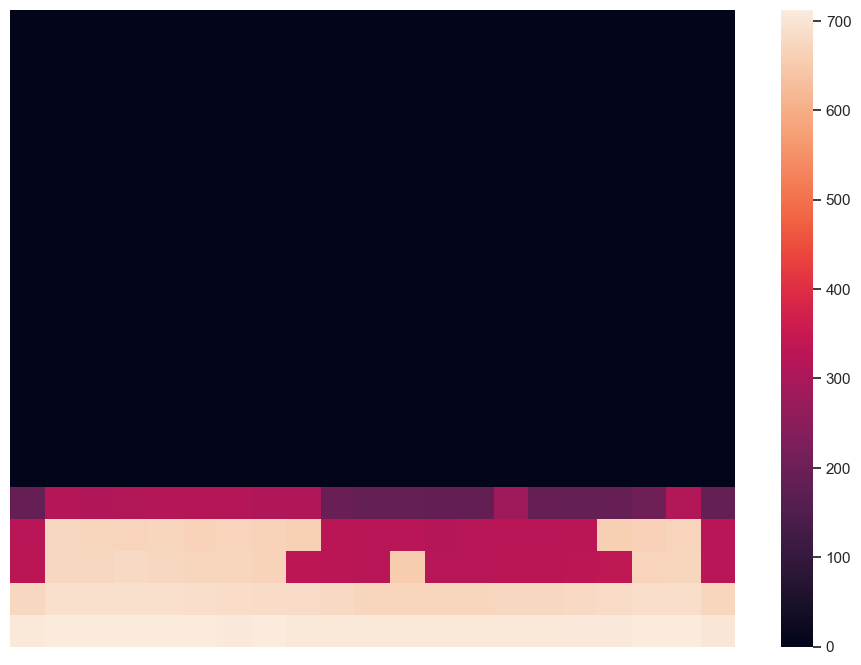

In [32]:
# Plot
ax = sns.heatmap(reversed_df)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel('')  
ax.set_xlabel('')  
print('')

<a id='step4'></a>